In [1]:
# ==========================================
# FACE RECOGNITION USING PCA + KNN (JUPYTER VERSION)
# Works in Google Colab or VS Code Jupyter
# ==========================================

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import display, clear_output

# ---------- CONFIG ----------
DATASET_PATH = "faces_dataset"
IMG_SIZE = (100, 100)
os.makedirs(DATASET_PATH, exist_ok=True)

# ---------- CAPTURE IMAGES ----------
def capture_face_data(person_name, num_images=3):
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    person_dir = os.path.join(DATASET_PATH, person_name)
    os.makedirs(person_dir, exist_ok=True)
    count = 0

    print(f"📸 Capturing {num_images} images for '{person_name}'... Press 'q' to stop.")

    while count < num_images:
        ret, frame = cap.read()
        if not ret:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            roi = gray[y:y+h, x:x+w]
            roi = cv2.resize(roi, IMG_SIZE)
            cv2.imwrite(os.path.join(person_dir, f"{count+1}.jpg"), roi)
            count += 1
            print(f"✅ Saved image {count}")
        
        # Inline display (instead of cv2.imshow)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        display(plt.gcf())
        plt.close()
        clear_output(wait=True)
    
    cap.release()
    print("✅ Capture complete.")

# --- Run once to capture your images ---
capture_face_data("Swarnim", num_images=3)


✅ Capture complete.


In [2]:
# ---------- LOAD DATASET ----------
def load_dataset(path=DATASET_PATH):
    images, labels, names = [], [], []
    people = [p for p in os.listdir(path) if os.path.isdir(os.path.join(path, p))]
    for label, person in enumerate(people):
        person_path = os.path.join(path, person)
        for file in os.listdir(person_path):
            img_path = os.path.join(person_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None or img.size == 0:
                continue
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype(np.float32) / 255.0
            images.append(img.flatten())
            labels.append(label)
        names.append(person)
    return np.array(images), np.array(labels), names

X, y, names = load_dataset()
print(f"📂 Loaded {len(X)} images of {len(names)} person(s): {names}")


📂 Loaded 3 images of 1 person(s): ['Swarnim']


In [3]:
# ---------- TRAIN PCA + KNN ----------
if len(X) == 0:
    raise ValueError("No images found. Capture face data first.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

n_components = min(20, len(X_train), X_train.shape[1])
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=min(3, len(np.unique(y_train))))
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully with accuracy: {acc*100:.2f}%")


✅ Model trained successfully with accuracy: 100.00%


In [4]:
# ---------- TEST ON LIVE CAMERA (INLINE PREVIEW) ----------
def recognize_live_inline(pca, knn, names, num_frames=20):
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    print("🎥 Recognizing faces...")

    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi = cv2.resize(gray[y:y+h, x:x+w], IMG_SIZE).astype(np.float32)/255.0
            roi_flat = roi.flatten().reshape(1, -1)
            face_pca = pca.transform(roi_flat)
            pred = knn.predict(face_pca)
            name = names[pred[0]]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        # Inline display
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        display(plt.gcf())
        plt.close()
        clear_output(wait=True)

    cap.release()
    print("✅ Recognition complete.")

# --- Run this to test recognition (shows inline frames) ---
recognize_live_inline(pca, knn, names, num_frames=20)


✅ Recognition complete.


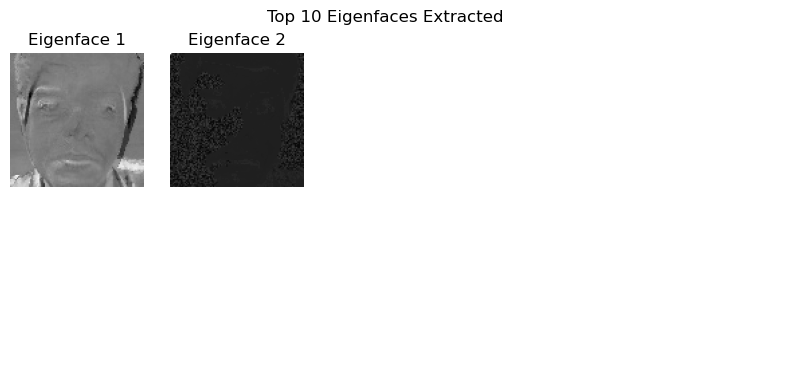

In [5]:
# ---------- VISUALIZE EIGENFACES ----------
eigenfaces = pca.components_.reshape((n_components, IMG_SIZE[0], IMG_SIZE[1]))

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < len(eigenfaces):
        ax.imshow(eigenfaces[i], cmap="gray")
        ax.set_title(f"Eigenface {i+1}")
    ax.axis("off")
plt.suptitle("Top 10 Eigenfaces Extracted")
plt.show()
